<a href="https://colab.research.google.com/github/Tim-Roket-Bangkit-2021/ML/blob/master/rr_forecast(Fix).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
!wget --no-check-certificate \
    'https://docs.google.com/uc?export=download&id=1RX0mU6l4Yna6-TKtcwASidYAJ70c766D' \
    -O /tmp/rr-malang-2015-2021May.csv

--2021-06-08 11:45:43--  https://docs.google.com/uc?export=download&id=1RX0mU6l4Yna6-TKtcwASidYAJ70c766D
Resolving docs.google.com (docs.google.com)... 108.177.125.139, 108.177.125.113, 108.177.125.102, ...
Connecting to docs.google.com (docs.google.com)|108.177.125.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-3k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ram3pv4cejln64alnur7tfs17kj6rbqn/1623152700000/05242472176789317516/*/1RX0mU6l4Yna6-TKtcwASidYAJ70c766D?e=download [following]
--2021-06-08 11:45:44--  https://doc-00-3k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ram3pv4cejln64alnur7tfs17kj6rbqn/1623152700000/05242472176789317516/*/1RX0mU6l4Yna6-TKtcwASidYAJ70c766D?e=download
Resolving doc-00-3k-docs.googleusercontent.com (doc-00-3k-docs.googleusercontent.com)... 64.233.189.132, 2404:6800:4008:c07::84
Connecting to doc-00-3k-docs.googleusercontent.com (doc-00-

In [3]:
df = pd.read_csv('/tmp/rr-malang-2015-2021May.csv')
df.head()

,ID,RR
0,1,0.9
1,2,2.1
2,3,0.8
3,4,NaN
4,5,0.9


In [4]:
df.describe(include='all')

,ID,RR
count,2339.000000,2084.000000
mean,1170.000000,6.660125
std,675.355462,14.287310
min,1.000000,0.000000
25%,585.500000,0.000000
50%,1170.000000,0.000000
75%,1754.500000,6.000000
max,2339.000000,145.000000


In [5]:
df.isna().sum()

ID      0
RR    255
dtype: int64

In [6]:
filled = df.fillna(df.mean())

In [7]:
filled.head()

,ID,RR
0,1,0.900000
1,2,2.100000
2,3,0.800000
3,4,6.660125
4,5,0.900000


In [8]:
filled.tail()

,ID,RR
2334,2335,0.000000
2335,2336,0.600000
2336,2337,0.000000
2337,2338,5.800000
2338,2339,6.660125


In [9]:
filled.isna().sum()

ID    0
RR    0
dtype: int64

In [10]:
filled.to_csv(r'/content/sample_data/filled-rr-malang-2015-2020.csv')

In [11]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Rainfall Rate")
    plt.grid(True)

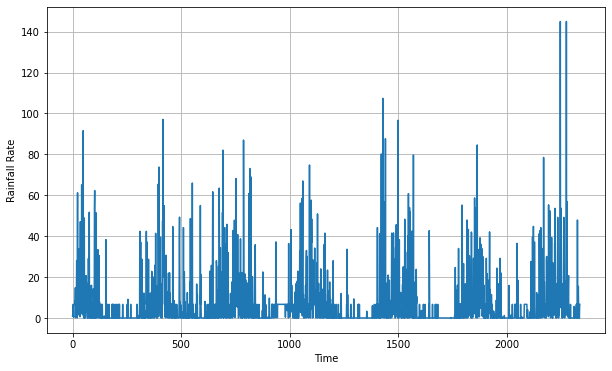

In [12]:
import csv
time_step = []
rr = []

with open('/content/sample_data/filled-rr-malang-2015-2020.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    rr.append(float(row[2]))
    time_step.append(step)
    step = step + 1

series = np.array(rr)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [13]:
split_time = 1500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 500

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [16]:
import tensorflow as tf

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(1500,)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
6/6 [==============================] - 33s 64ms/step - loss: 10.9711 - mae: 11.4410
Epoch 2/100
6/6 [==============================] - 0s 51ms/step - loss: 10.9629 - mae: 11.4333
Epoch 3/100
6/6 [==============================] - 0s 51ms/step - loss: 10.9491 - mae: 11.4201
Epoch 4/100
6/6 [==============================] - 0s 49ms/step - loss: 10.9317 - mae: 11.4035
Epoch 5/100
6/6 [==============================] - 0s 55ms/step - loss: 10.9116 - mae: 11.3842
Epoch 6/100
6/6 [==============================] - 0s 47ms/step - loss: 10.8886 - mae: 11.3620
Epoch 7/100
6/6 [==============================] - 0s 54ms/step - loss: 10.8633 - mae: 11.3372
Epoch 8/100
6/6 [==============================] - 0s 52ms/step - loss: 10.8366 - mae: 11.3110
Epoch 9/100
6/6 [==============================] - 0s 51ms/step - loss: 10.8082 - mae: 11.2831
Epoch 10/100
6/6 [==============================] - 0s 53ms/step - loss: 10.7779 - mae: 11.2534
Epoch 11/100
6/6 [==============================

(1e-08, 0.0001, 0.0, 60.0)

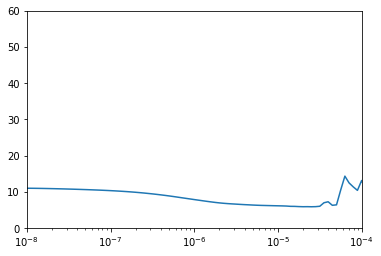

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=2e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/500
15/15 [==============================] - 4s 37ms/step - loss: 11.3124 - mae: 11.7941
Epoch 2/500
15/15 [==============================] - 1s 35ms/step - loss: 6.1240 - mae: 6.5840
Epoch 3/500
15/15 [==============================] - 1s 35ms/step - loss: 5.8539 - mae: 6.3115
Epoch 4/500
15/15 [==============================] - 1s 36ms/step - loss: 5.7374 - mae: 6.1692
Epoch 5/500
15/15 [==============================] - 1s 34ms/step - loss: 5.7305 - mae: 6.1737
Epoch 6/500
15/15 [==============================] - 1s 34ms/step - loss: 5.6854 - mae: 6.1160
Epoch 7/500
15/15 [==============================] - 1s 34ms/step - loss: 5.6570 - mae: 6.0829
Epoch 8/500
15/15 [==============================] - 1s 35ms/step - loss: 5.6569 - mae: 6.0807
Epoch 9/500
15/15 [==============================] - 1s 35ms/step - loss: 5.6673 - mae: 6.1011
Epoch 10/500
15/15 [==============================] - 1s 35ms/step - loss: 5.6352 - mae: 6.0635
Epoch 11/500
15/15 [===========================

In [19]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

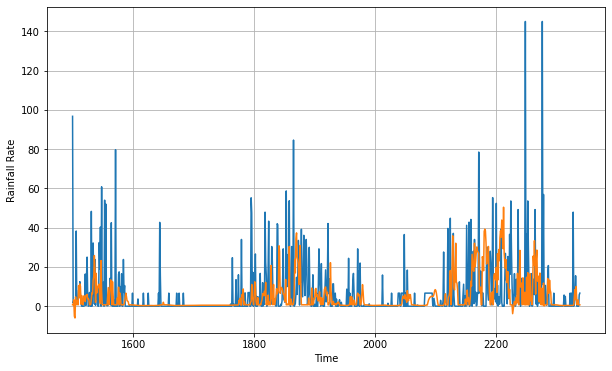

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

7.392483

In [22]:
print(rnn_forecast)

[ 0.7162222   0.7162222   3.2663596  -5.0855613  -5.9905744   4.729348
  0.7162222   2.4087691   2.9084263   0.7162222  10.409486    4.2453265
 11.394678   10.135524    1.0159527   5.424184    2.184683    0.7162222
  3.8117263   5.3185735   3.4214807   2.3502333   5.526338    5.587946
  6.0051956   3.710856    3.930921    3.2983835   0.7162222   0.7162222
  0.9836366   3.4516468   6.82781     6.355797   13.160496   15.076895
 25.798803   18.719334    1.9227272  16.748428    6.71503     8.825907
  9.826488   10.773957   11.255448    2.84221     1.3819102  23.234983
  7.606921    0.7162222   0.7162222   0.7162222   0.7162222   0.7162222
  0.7162222   0.7162222   0.7162222   0.7162222   4.9486947   9.50044
  0.7162222   4.336216    8.877141   13.400078   13.141184    0.7162222
 12.500694    5.821351    0.7162222   0.7162222   0.7162222   0.7162222
  0.7162222   0.7162222   4.1395097   1.6120036   9.688106    0.7162222
  6.7829847   5.4440594   0.7162222   0.7162222   0.7162222   0.7162222

<Figure size 432x288 with 0 Axes>

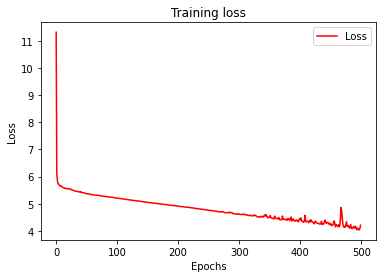

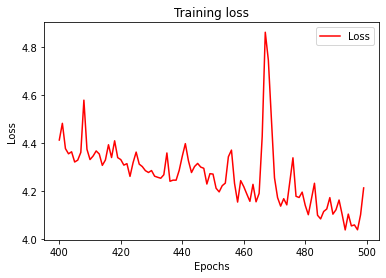

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[400:]
zoomed_epochs = range(400,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [24]:
print(series[2308:2338])

[ 0.          0.          0.          0.7         5.7         0.
  5.          0.          0.          0.          0.          0.
  0.          0.          6.66012476  0.          6.66012476  0.
  0.1        47.9         0.          1.4         6.66012476 15.5
  6.66012476  0.          0.          0.6         0.          5.8       ]


In [25]:
save = pd.DataFrame(rnn_forecast)

In [26]:
save.head()

,0
0,0.716222
1,0.716222
2,3.266360
3,-5.085561
4,-5.990574


In [27]:
save.to_csv(r'/content/sample_data/predicted-rr-malang-2015-2021May.csv')

In [28]:
save.to_json(r'/content/sample_data/predicted-rr-malang-2015-2021May.json')

In [29]:
print(series[2309:2339][np.newaxis])

[[ 0.          0.          0.7         5.7         0.          5.
   0.          0.          0.          0.          0.          0.
   0.          6.66012476  0.          6.66012476  0.          0.1
  47.9         0.          1.4         6.66012476 15.5         6.66012476
   0.          0.          0.6         0.          5.8         6.66012476]]


In [30]:
training_data = pd.DataFrame(series)

In [31]:
training_data

,0
0,0.900000
1,2.100000
2,0.800000
3,6.660125
4,0.900000
...,...
2334,0.000000
2335,0.600000
2336,0.000000
2337,5.800000


In [32]:
save.to_csv(r'/content/sample_data/training-rr-malang-2015-2021May.csv')

In [33]:
save.to_json(r'/content/sample_data/training-rr-malang-2015-2021May.json')

In [34]:
print(train_set)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [89]:
predictMay = model_forecast(model, series[...,np.newaxis], 30)
predictMay = predictMay[2279:-1, -1, 0]
print(predictMay)

[ 0.3568921   0.37419164  0.3898568   0.40681818  0.43846312  0.4285943
  0.44252533  0.43811026  0.44720605  0.4084539   0.3668709   0.34193528
  0.33906242  0.33571583  0.37767762  0.38274845  0.41649306  0.42363107
  0.42693374  0.6206833   5.664511    8.736292    3.9914987  10.548099
  1.1970742   0.7162222   3.2486405   0.7162222   0.7162222   0.7162222 ]


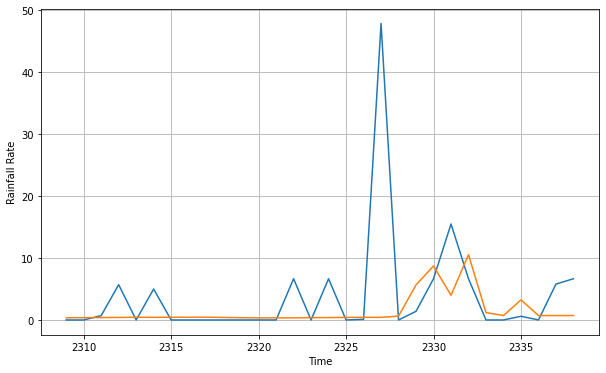

In [91]:
plt.figure(figsize=(10, 6))
plot_series(time[2309:],series[2309:])
plot_series(time[2309:],predictMay)

In [94]:
predictApril = model_forecast(model, series[...,np.newaxis], 30)
predictApril = predictApril[2248:2278, -1, 0]
print(len(predictApril))

30


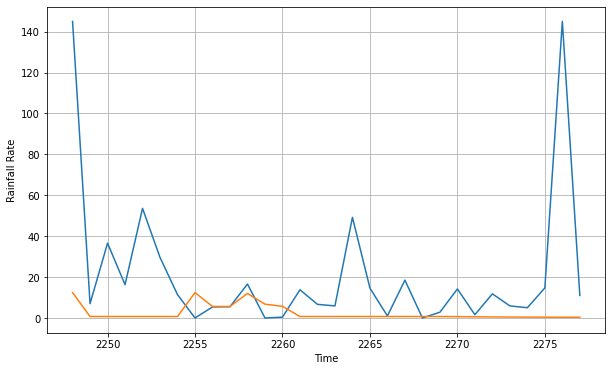

In [97]:
plt.figure(figsize=(10, 6))
plot_series(time[2248:2278],series[2248:2278])
plot_series(time[2248:2278],predictApril)